In [3]:
#installing dependencies

_ = !pip3 install pycoingecko
_ = !pip3 install --upgrade pip
_ = !pip3 install skforecast

_ = !pip3 install lightgbm

# _ = !pip3 install --upgrade nbformat

In [4]:
from pycoingecko import CoinGeckoAPI
cg = CoinGeckoAPI()

In [5]:
#Define coin to analize

coin = 'bitcoin'

## Get data from the API

In [6]:
import pandas as pd
import time 

data  = cg.get_coin_market_chart_by_id(id=coin,vs_currency='usd',days='3000')

#calculate the time to get data
start_time = time.time()
#group data by date

#make a dataframe from the data just with the [1] column values
df1 = pd.DataFrame(data['prices'], columns=['time', 'prices'])
df2 = pd.DataFrame(data['market_caps'], columns=['time', 'market_cap'])
df3 = pd.DataFrame(data['total_volumes'], columns=['time', 'total_volume'])
df = pd.merge(df1, df2, on='time')
df = pd.merge(df, df3, on='time')
#add a column with the date
df['date'] = df['time'].apply(lambda x: pd.to_datetime(x, unit='ms')).apply(lambda x: x.date())

#make extra features
df_low = df.groupby('date')['prices'].min().reset_index()
df_low.columns = ['date', 'low_price']
df_high = df.groupby('date')['prices'].max().reset_index()
df_high.columns = ['date', 'high_price']
df_open = df.groupby('date')['prices'].first().reset_index()
df_open.columns = ['date', 'open_price']

#merge new features into a dataframe
df2 = pd.merge(df_low, df_high, on='date')
df2 = pd.merge(df2, df_open, on='date')

#join data with the original dataframe
df = pd.merge(df, df2, on='date')
#drop the time column
df.drop('time', axis=1, inplace=True)
#remove duplicates dates
df.drop_duplicates(subset='date', keep='first', inplace=True)

#reorder columns
data = df[['date', 'open_price', 'high_price', 'low_price', 'prices', 'market_cap', 'total_volume']]

data.columns = ['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Market Cap']
end_time = time.time()

#print formated in seconds with 2 decimals
print('Time to get data: {:.2f} seconds'.format(end_time - start_time))
print(data.shape)
data.head()


Time to get data: 0.15 seconds
(2999, 7)


Date        Open        High         Low       Close        Volume  \
0  2014-08-04  586.368686  586.368686  586.368686  586.368686  7.681459e+09   
1  2014-08-05  582.418627  582.418627  582.418627  582.418627  7.631722e+09   
2  2014-08-06  583.325000  583.325000  583.325000  583.325000  7.645918e+09   
3  2014-08-07  587.203159  587.203159  587.203159  587.203159  7.699129e+09   
4  2014-08-08  590.907270  590.907270  590.907270  590.907270  7.749970e+09   

     Market Cap  
0  1.132598e+07  
1  1.304678e+07  
2  1.276992e+07  
3  1.194267e+07  
4  1.227759e+07

In [7]:
# Preparación del dato
# ==============================================================================
data['date'] = pd.to_datetime(data['Date'], format='%Y-%m-%d %H:%M:%S')
data = data.loc[:, ['date', 'Open', 'Close', 'High', 'Low']]
data = data.rename({'Open': 'open', 'Close': 'close', 'High': 'high', 'Low': 'low'}, 
                    axis=1)
data = data.set_index('date')
data = data.asfreq('D')
data = data.sort_index()

/var/folders/gg/kzl9y6_96xl3btl406q1nngh0000gq/T/ipykernel_34864/3949839228.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['date'] = pd.to_datetime(data['Date'], format='%Y-%m-%d %H:%M:%S')


In [8]:
print(f'Número de filas con missing values: {data.isnull().any(axis=1).mean()}')

Número de filas con missing values: 0.0003333333333333333


## Halving del Bitcoin como variable exógena

El Halving es un evento programado y forma parte del diseño y funcionamiento de algunas criptomonedas. Los mineros se dedican a validar los bloques de transacciones de la red, en este caso Bitcoin, y, cada vez que lo logran, reciben como recompensa una cantidad de esa moneda digital. Esta cantidad es fija pero solo durante un tiempo.

En la blockchain de Bitcoin, cada vez que se añaden 210.000 bloques ocurre el cambio de recompensa. Este hecho, denominado como halving, se produce aproximadamente cada 4 años y reduce a la mitad las monedas que reciben los mineros.

En la historia de Bitcoin han existido 3 halvings. Cuando se lanzó la minería de Bitcoin, los mineros recibían 50 BTC al extraer con éxito un bloque. En 2012 esta recompensa se redujo a 25 BTC, en 2016 bajó a 12,5 BTC, y en 2020 a 6,25 BTC, después del tercer halving. Por lo general, cada halving ha tenido un impacto en el precio aunque no necesariamente ha sido en el corto plazo.

Se pretende utilizar los días restantes para el próximo halving y sus recompensas de minado como variables exógenas para predecir el precio de Bitcoin. Se calcula que el próximo halving ocurrirá aproximadamente en 2024 aunque se desconoce su fecha exacta. Para estimarla, se toman los bloques restantes a fecha de 2022-01-14 de la página web Coinmarketcap, 121.400, y se utiliza el promedio de los bloques de la red Bitcoin minados por día, 144 (tiempo de bloque promedio  ≈  10 minutos).

Nota: Al incorporar datos predichos como una variable exógena, se introduce, dado que se trata de predicciones, su error en el modelo de forecasting.

In [9]:
import numpy as np
import datetime
# Dict con la info de los halvings del Bitcoin
# ==============================================================================
btc_halving = {'halving'              : [0, 1 , 2, 3, 4],
               'date'                 : ['2009-01-03', '2012-11-28', 
                                         '2016-07-09', '2020-05-11', np.nan],
               'reward'               : [50, 25, 12.5, 6.25, 3.125],
               'halving_block_number' : [0, 210000, 420000 ,630000, 840000]
              }
# Cálculo siguiente halving
# Se toma como base de partida los bloques restantes según la web 
# coinmarketcap.com para el próximo halving a fecha de 2022-01-14
# ==============================================================================
bloques_restantes = 121400
bloques_por_dia = 144

dias = bloques_restantes / bloques_por_dia

next_halving = pd.to_datetime('2022-01-14', format='%Y-%m-%d') + datetime.timedelta(days=dias)
next_halving = next_halving.replace(microsecond=0, second=0, minute=0, hour=0)
next_halving = next_halving.strftime('%Y-%m-%d')

btc_halving['date'][-1] = next_halving

print(f'El próximo halving ocurrirá aproximadamente el: {next_halving}')

El próximo halving ocurrirá aproximadamente el: 2024-05-06


In [10]:
# Incluir recompensas y cuenta regresiva para próximo halving en el dataset
# ==============================================================================
data['reward'] = np.nan
data['countdown_halving'] = np.nan

for i in range(len(btc_halving['halving'])-1):
     
    # Fecha inicial y final de cada halving
    if btc_halving['date'][i] < data.index.min().strftime('%Y-%m-%d'):
        start_date = data.index.min().strftime('%Y-%m-%d')
    else:
        start_date = btc_halving['date'][i]
        
    end_date = btc_halving['date'][i+1]
    mask = (data.index >= start_date) & (data.index < end_date)
        
    # Rellenar columna 'reward' con las recompensas de minería
    data.loc[mask, 'reward'] = btc_halving['reward'][i]
    
    # Rellenar columna 'countdown_halving' con los días restantes
    time_to_next_halving = pd.to_datetime(end_date) - pd.to_datetime(start_date)
    
    data.loc[mask, 'countdown_halving'] = np.arange(time_to_next_halving.days)[::-1][:mask.sum()]

In [11]:
# Comprobar que se han creado los datos correctamente
# ==============================================================================
print('Segundo halving:', btc_halving['date'][2])
display(data.loc['2016-07-08':'2016-07-09'])
print('')
print('Tercer halving:', btc_halving['date'][3])
display(data.loc['2020-05-10':'2020-05-11'])
print('')
print('Próximo halving:', btc_halving['date'][4])
data.tail(2)

Segundo halving: 2016-07-09


open       close        high         low  reward  \
date                                                                 
2016-07-08  665.744506  665.744506  665.744506  665.744506    25.0   
2016-07-09  653.870512  653.870512  653.870512  653.870512    12.5   

            countdown_halving  
date                           
2016-07-08                0.0  
2016-07-09             1401.0


Tercer halving: 2020-05-11


open        close         high          low  reward  \
date                                                                     
2020-05-10  9566.777187  9566.777187  9566.777187  9566.777187   12.50   
2020-05-11  8752.617088  8752.617088  8752.617088  8752.617088    6.25   

            countdown_halving  
date                           
2020-05-10                0.0  
2020-05-11             1455.0


Próximo halving: 2024-05-06


open         close          high           low  reward  \
date                                                                         
2022-10-19  19348.029369  19348.029369  19348.029369  19348.029369    6.25   
2022-10-20  19134.242664  19134.242664  19143.825191  19134.242664    6.25   

            countdown_halving  
date                           
2022-10-19              564.0  
2022-10-20              563.0

### Exploración gráfica

Cuando se quiere generar un modelo de forecasting, es importante representar los valores de la serie temporal. Esto permite identificar patrones tales como tendencias y estacionalidad.

### Gráfico de velas

Un gráfico de velas japonesas es un tipo de gráfico muy utilizado en el mundo del análisis técnico. El cuerpo de la vela indica la variación entre el precio de apertura y cierre, para un periodo determinado, mientras que los pelos o sombras indican los valores mínimo y máximo alcanzados durante ese periodo.

In [12]:
# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt
%matplotlib inline
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
plt.style.use('ggplot')

# Colores Bitcoin
# ==============================================================================
palette_btc = {'naranja': '#f7931a',
               'blanco' : '#ffffff',
               'gris'   : '#4d4d4d',
               'azul'   : '#0d579b',
               'verde'  : '#329239'
              }

# Gráfico de velas japonesas interactivo con Plotly
# ==============================================================================
candlestick = go.Candlestick(
                  x     = data.index,
                  open  = data.open,
                  close = data.close,
                  low   = data.low,
                  high  = data.high,
              )

fig = go.Figure(data=[candlestick])

fig.update_layout(
    width       = 900,
    height      = 450,
    title       = dict(text='<b>Chart Bitcoin/USD</b>', font=dict(size=30)),
    yaxis_title = dict(text='Precio (USD)', font=dict(size=15)),
    margin      = dict(l=10, r=20, t=80, b=20),
    shapes      = [dict(x0=btc_halving['date'][2], x1=btc_halving['date'][2], 
                        y0=0, y1=1, xref='x', yref='paper', line_width=2),
                   dict(x0=btc_halving['date'][3], x1=btc_halving['date'][3], 
                        y0=0, y1=1, xref='x', yref='paper', line_width=2),
                   dict(x0=btc_halving['date'][4], x1=btc_halving['date'][4], 
                        y0=0, y1=1, xref='x', yref='paper', line_width=2)
                  ],
    annotations = [dict(x=btc_halving['date'][2], y=1, xref='x', yref='paper',
                      showarrow=False, xanchor='left', text='Segundo halving'),
                   dict(x=btc_halving['date'][3], y=1, xref='x', yref='paper',
                      showarrow=False, xanchor='left', text='Tercer halving'),
                   dict(x=btc_halving['date'][4], y=1, xref='x', yref='paper',
                      showarrow=False, xanchor='left', text='Cuarto halving')
                  ],
    xaxis_rangeslider_visible = False,
)

fig.show()

### Distribución de los datos

Se muestra la distribución del precio de cierre de Bitcoin, variable close:

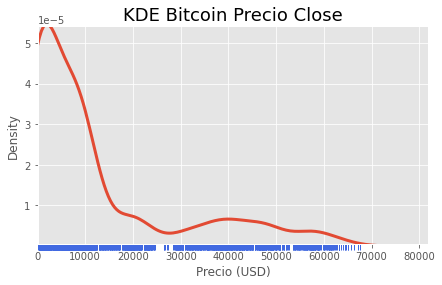

In [13]:
# Distribución KDE del precio de cierre del Bitcoin
# ==============================================================================
fig, ax = plt.subplots(figsize=(7, 4))
p = sns.kdeplot(data=data, x='close', linewidth=3, ax=ax)
r = sns.rugplot(data=data, x='close', ax=ax, c='royalblue',
                height=-.03, clip_on=False)
p.set(xlim=(0, None))
p.set_title('KDE Bitcoin Precio Close', fontsize=18)
p.set_xlabel('Precio (USD)');

In [14]:
# Se localizan los datos correspondientes para cada año
# ==============================================================================
years = list(data.index.year.unique())
df_plot = pd.DataFrame()

for year in years:
    
    year_open  = data.loc[data.index.year == year, 'open'][0]
    year_close = data.loc[data.index.year == year, 'close'][-1]
    year_low   = data.loc[data.index.year == year, 'low'].min()
    year_high  = data.loc[data.index.year == year, 'high'].max()
    
    df_plot[year] = pd.Series([year_open, year_close, year_low, year_high]) 
    
df_plot = df_plot.T
df_plot = df_plot.set_axis(['open', 'close', 'low', 'high'], axis=1)

# Se calcula el % de cambio entre el open y el close del año
# ==============================================================================
df_plot['year_change'] = 100*(df_plot['close'] - df_plot['open']) / df_plot['open']
df_plot.tail(5)

open         close           low          high  year_change
2018  14093.606831   3809.728229   3216.627150  18343.662493   -72.968394
2019   3692.531566   7240.428912   3394.014653  12996.124343    96.083061
2020   7195.153895  28837.288529   5032.501351  28837.288529   300.787654
2021  29022.418395  47191.868390  29022.418395  67617.015545    62.604879
2022  46319.651088  19134.242664  18539.635238  47816.077676   -58.690875

In [15]:
# Se crea una lista de dicts con las anotaciones de % de cambio para el gráfico
# ==============================================================================
annotations_list = []
max_high = df_plot['high'].max()

for year in years:
    
    df_aux = df_plot.loc[df_plot.index == year,]
    loc_x  = pd.to_datetime(df_aux.index[0], format='%Y')
    loc_y  = df_aux['high'].values[0]/max_high + 0.05
    text   = '{:.1f}%'.format(df_aux['year_change'].values[0])
    
    annotation = dict(x=loc_x, y=loc_y, 
                      xref='x', yref='paper',
                      showarrow=False, xanchor='center', 
                      text=text)

    annotations_list.append(annotation)

# Gráfico de velas japonesas anual interactivo con Plotly
# ==============================================================================
candlestick = go.Candlestick(
                  x     = pd.to_datetime(df_plot.index, format='%Y'),
                  open  = df_plot.open,
                  close = df_plot.close,
                  low   = df_plot.low,
                  high  = df_plot.high
              )

fig = go.Figure(data=[candlestick])

fig.update_layout(
    width       = 800,
    height      = 350,
    title       = dict(text='<b>Chart Bitcoin/USD por año</b>', font=dict(size=25)),
    yaxis_title = dict(text='Precio (USD)', font=dict(size=13)),
    margin      = dict(l=0, r=20, t=55, b=20),
    xaxis_rangeslider_visible = False,
    annotations = annotations_list
)

fig.show()

In [16]:
# Se localizan los datos correspondientes para cada mes
# ==============================================================================
years = list(data.index.year.unique())
df_plot = pd.DataFrame()

for year in years:
    for mes in range(12):
        
        start_date = pd.to_datetime(f'{year}-{mes+1}-01', format='%Y-%m-%d')
        end_date = (start_date + pd.offsets.MonthBegin())
        mask = (data.index >= start_date) & (data.index < end_date)
        
        if not data.loc[mask, :].empty:
                        
            month_open  = data.loc[mask, 'open'][0]
            month_close = data.loc[mask, 'close'][-1]
            month_low   = data.loc[mask, 'low'].min()
            month_high  = data.loc[mask, 'high'].max()
            
            serie  = pd.Series([month_open, month_close, month_low, month_high])
            df_aux = pd.DataFrame(serie, columns=[f'{str(mes+1).zfill(2)}-{year}'])
            
            if df_plot.empty:
                df_plot = df_aux.copy()
            else:
                df_plot = pd.concat([df_plot, df_aux], axis=1)

df_plot = df_plot.T
df_plot = df_plot.set_axis(['open', 'close', 'low', 'high'], axis=1)

In [17]:
# Gráfico boxplot para estacionalidad anual
# ==============================================================================
# df_plot['mes'] = pd.to_datetime(df_plot.index, format='%m-%Y').month
# fig, ax = plt.subplots(figsize=(7, 3.5))
# df_plot.boxplot(column='close', by='mes', ax=ax)
# df_plot.groupby('mes')['close'].median().plot(style='o-', linewidth=0.8, ax=ax)
# ax.set_ylabel('Precio (USD)')
# ax.set_title('BTC Precio por mes')
# fig.suptitle('');

df_plot['mes'] = pd.to_datetime(df_plot.index, format='%m-%Y').month

# fig 1 boxplot de los meses
fig1 = px.box(df_plot.sort_values('mes'), x='mes', y='close',
              color_discrete_sequence=[palette_btc['verde']])

# fig 2 line con datos de la mediana de cada mes
df_median = pd.DataFrame(df_plot.groupby('mes')['close'].median()).reset_index()
fig2 = px.line(df_median, x='mes', y='close', markers=True,
               color_discrete_sequence=[palette_btc['gris']])

fig = go.Figure(data=fig1.data + fig2.data)

fig.update_layout(
    width       = 650,
    height      = 350,
    title       = dict(text='<b>BTC Precio por mes</b>', font=dict(size=25)),
    yaxis_title = dict(text='Precio (USD)', font=dict(size=13)),
    xaxis       = dict(tickmode='linear'),
    xaxis_title = dict(text='mes', font=dict(size=13)),
    margin      = dict(l=0, r=20, t=55, b=20)
)

fig.show()

In [18]:
# Gráfico boxplot para estacionalidad mensual
# ==============================================================================
# fig, ax = plt.subplots(figsize=(9, 3.5))
# data['dia_mes'] = pd.Series(data.index).dt.day.values
# data.boxplot(column='close', by='dia_mes', ax=ax)
# data.groupby('dia_mes')['close'].median().plot(style='o-', linewidth=0.8, ax=ax)
# ax.set_ylabel('Precio (USD)')
# ax.set_title('BTC Precio por día del mes')
# fig.suptitle('');

data['dia_mes'] = pd.Series(data.index).dt.day.values

# fig 1 boxplot de los días del mes
fig1 = px.box(data.sort_values('dia_mes'), x='dia_mes', y='close',
              color_discrete_sequence=[palette_btc['verde']])

# fig 2 line con datos de la mediana de los días del mes
df_median = pd.DataFrame(data.groupby('dia_mes')['close'].median()).reset_index()
fig2 = px.line(df_median, x='dia_mes', y='close', markers=True,
               color_discrete_sequence=[palette_btc['gris']])

fig = go.Figure(data=fig1.data + fig2.data)

fig.update_layout(
    width       = 750,
    height      = 350,
    title       = dict(text='<b>BTC Precio por día del mes</b>', font=dict(size=25)),
    yaxis_title = dict(text='Precio (USD)', font=dict(size=13)),
    xaxis       = dict(tickmode='linear', tickangle=0, range=[0.5, 31.5]),
    xaxis_title = dict(text='día', font=dict(size=13)),
    margin      = dict(l=0, r=20, t=55, b=20)
)

fig.show()

In [19]:
# Gráfico boxplot para estacionalidad semanal
# ==============================================================================
# fig, ax = plt.subplots(figsize=(7, 3.5))
# data['dia_semana'] = data.index.day_of_week + 1
# data.boxplot(column='close', by='dia_semana', ax=ax)
# data.groupby('dia_semana')['close'].median().plot(style='o-', linewidth=0.8, ax=ax)
# ax.set_ylabel('Precio (USD)')
# ax.set_title('BTC Precio por día de la semana');

data['dia_semana'] = data.index.day_of_week + 1

# fig 1 boxplot de los días de la semana
fig1 = px.box(data.sort_values('dia_semana'), x='dia_semana', y='close',
              color_discrete_sequence=[palette_btc['verde']])

# fig 2 line con datos de la mediana los días de la semana
df_median = pd.DataFrame(data.groupby('dia_semana')['close'].median()).reset_index()
fig2 = px.line(df_median, x='dia_semana', y='close', markers=True,
               color_discrete_sequence=[palette_btc['gris']])

fig = go.Figure(data=fig1.data + fig2.data)

fig.update_layout(
    width       = 650,
    height      = 350,
    title       = dict(text='<b>BTC Precio por día de la semana</b>', font=dict(size=25)),
    yaxis_title = dict(text='Precio (USD)', font=dict(size=13)),
    xaxis       = dict(tickmode='linear'),
    xaxis_title = dict(text='día de la semana', font=dict(size=13)),
    margin      = dict(l=0, r=20, t=55, b=20)
)

fig.show()

In [20]:
# Modelado y Forecasting
# ==============================================================================
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.model_selection import backtesting_forecaster
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_absolute_error
# Gráfico autocorrelación
# ==============================================================================
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 4))
axes = axes.flat
plot_acf(data.close, ax=axes[0], linewidth = 1, lags=100)
axes[0].set_ylim(-1.1, 1.1)
plot_acf(data.close, ax=axes[1], linewidth = 1, lags=730)
axes[1].set_ylim(-1.1, 1.1)
plt.show();

ModuleNotFoundError: No module named 'skforecast'

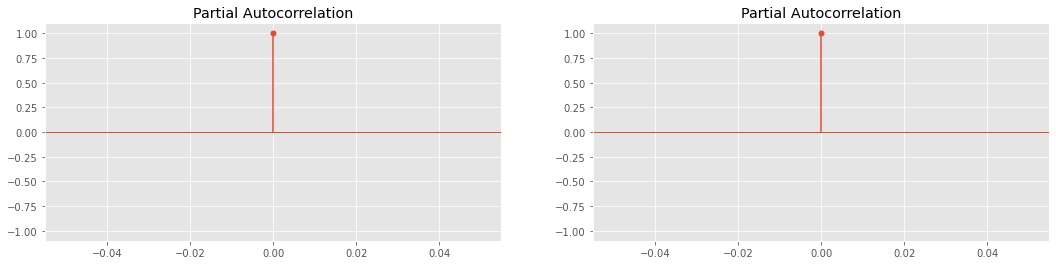

In [56]:
# Gráfico autocorrelación parcial
# ==============================================================================
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 4))
axes = axes.flat
plot_pacf(data.close, ax=axes[0], lags=20, method='ywm',  linewidth = 1)
axes[0].set_ylim(-1.1, 1.1)
plot_pacf(data.close, ax=axes[1], lags=730, method='ywm',  linewidth = 1)
axes[1].set_ylim(-1.1, 1.1)
plt.show();

In [57]:
# Selección fechas train-test
# ==============================================================================
inicio_train = '2020-01-01 00:00:00'
fin_train = '2021-06-30 23:59:59'

print(f"Serie temporal completa : {data.index.min()} --- {data.index.max()}  (n={len(data)})")
print(f"Fechas train            : {data.loc[inicio_train:fin_train].index.min()} --- {data.loc[inicio_train:fin_train].index.max()}  (n={len(data.loc[inicio_train:fin_train])})")
print(f"Fechas test             : {data.loc[fin_train:].index.min()} --- {data.loc[fin_train:].index.max()}  (n={len(data.loc[fin_train:])})")

Serie temporal completa : 2014-08-04 00:00:00 --- 2022-10-20 00:00:00  (n=3000)
Fechas train            : 2020-01-01 00:00:00 --- 2021-06-30 00:00:00  (n=547)
Fechas test             : 2021-07-01 00:00:00 --- 2022-10-20 00:00:00  (n=477)


In [58]:
# Simulación Random Walk
# ==============================================================================
df_rw = data[['close']].copy()
df_rw['pred_close'] = df_rw['close'].shift(1)

# Error de test
# ==============================================================================
y_true = df_rw.loc[fin_train:, 'close']
y_pred = df_rw.loc[fin_train:, 'pred_close']
metrica = mean_absolute_error(y_true, y_pred)

print(f'Error de test: {metrica}')
display(df_rw.loc[fin_train:,].head(4))

NameError: name 'mean_absolute_error' is not defined